# **4. Modeling**

In this stage I'll train different ML models, and tuning them also. At the end I'll select the best model.

To select the best model I have to define the model metrics to evaluate. I've to consider the following:

1. Model can't be too slow;
2. Model can't be too complex (must be understandable);
3. Model must prioritize specificity.

With this in mind we can conclude that:

* I can't use slow models like SVMs (Support Vector Machines);
* I probaly mustn't use neural networks (at least at this first moment) due to the difficulty of interpretability;
* A good metric for evaluating the model is by plotting the corresponding ROC curve(wich represent sensibility versus 1 - specificity).

The models I'll be testing are:

* **Logistic Regression**
* **Random Forest**
* **XGBoost**
* **CatBoost**

### **The Plan**

At a first moment I'll run each model whithout any tuning and select the best model. If two or more model appears similar, then I'll select them all. Before it, I'll tune the selected model(s) with cross validation to avoid overffiting. And then, finally I'll select the best model and test it on the test data.

## **Importing Libraries**

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform
from scipy.stats import randint

# text preprocessing module loader
from src.utils import load_object

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

# cross-validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

# model tune
from sklearn.model_selection import RandomizedSearchCV

# ensemble
from sklearn.ensemble import VotingClassifier

In [2]:
# set seaborn style
sns.set_style("darkgrid")

## **Loading Training Data And Applying Preprocessing**

In [3]:
# load preprocessor
preprocessor = load_object('../artifacts/preprocessor.pkl')

In [4]:
# laod data
data = pd.read_csv('../artifacts/train.csv')

In [5]:
# split data
X = data.iloc[:, 0].values
y = data.iloc[:, 1].values

In [6]:
# apply preprocessing
X = preprocessor.transform(X)

## **Model Evaluation Pipeline**

In [7]:
def plot_pr_vs_limiar(precisions, recalls, limiars, label, ax, show_limiar_intersection, alpha=1):
    '''
    Helper function to plot precision/recall X limiar.
    '''

    # calculate best recall and precision intersection
    intersection_idx = np.argmin(np.abs(precisions - recalls))
    intersection_limiar = limiars[intersection_idx]

    # plot
    ax.plot(limiars, precisions, label=f'{label} - precision', alpha=alpha)
    ax.plot(limiars, recalls, label=f'{label} - recall', alpha=alpha)

    # plot best limiar
    if show_limiar_intersection:
        ax.axvline(intersection_limiar, label=f'Best limiar = {round(intersection_limiar, 2)}', alpha=alpha/2)

    # config plot
    ax.set_title('Precision/Recall X Limiar', fontsize=16)
    ax.set_xlabel('Limiar')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.legend(loc='lower right')

def plot_roc_curve(fpr, tpr, label, ax, filled=True, alpha=1):
    '''
    Helper function to plot a roc curve.
    '''

    # plot curve
    ax.plot(fpr, tpr, label=label, alpha=alpha)

    if filled:
        ax.fill_between(fpr, tpr, alpha=alpha/2)

    # config plot
    ax.set_title('Roc Curve', fontsize=16)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.legend(loc='lower right')

def plot_confusion_matrix(title, y_true, y_pred, ax):
    '''
    Helper function to plot a confusion matrix.
    '''

    # calculate confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)

    # normalize matrix
    norm_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    # plot matrix
    sns.heatmap(norm_conf_mat, square=True, annot=True, cbar=False, ax=ax)

    # config plot
    ax.set_title(f'\n{title}', fontsize=16)
    ax.set_xlabel('Model Prediction')
    ax.set_ylabel('True Value')

def plot_classification_report(y_true, y_pred, ax):
    '''
    Helper function to plot sklearn classification report.
    '''

    # get classification report
    class_report = classification_report(y_true, y_pred, target_names=['No', 'Yes'], digits=5)

    # build table
    report_lines = class_report.split('\n')
    report_columns = [''] + report_lines[0].split()
    report_data = [[line.split()[0]] + list(line.split()[1:]) for line in report_lines[2:4]]
    report_data = report_data + [[''] * len(report_columns)]
    report_data = report_data + [['accuracy', '', ''] + list(report_lines[5].split()[1:])]
    report_table = [report_columns] + report_data

    # plot table
    ax.axis('off')
    table = ax.table(cellText=report_table, loc='center', cellLoc='right', colWidths=[0.25] * len(report_columns))
    table.set_fontsize(12)
    table.scale(0.7, 1.2)

    for _, cell in table.get_celld().items():
        cell.set_linewidth(0)

def evaluate_model(model, X, y, limiar=0.5):
    '''
    Function to evaluate the given ML model performance.
    This function shows:

    * Train/Predction times
    * Precision/Recall X Limiar
    * ROC curve
    * Confusion matrix (train and validation data)
    * Classifiaction report (train and validation data)
    
    Parameters
    ---
    * model: ML model to evaluate performance
    * X: input features
    * y: target feature
    * limiar: model decision limiar
    '''

    # train model and measure execution time
    train_start = time.time()
    model.fit(X, y)
    train_end = time.time()

    # predict probabilities and measure execution time
    pred_start = time.time()
    y_pred_probas = model.predict_proba(X)
    pred_end = time.time()

    # calcualte execution time
    train_time = train_end - train_start
    pred_time = pred_end - pred_start

    # cross-validation with stratified fold
    y_val_probas = cross_val_predict(model, X, y, 
                                     cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                                     method='predict_proba')
    
    # get scores
    y_pred_scores = y_pred_probas[:, 1]
    y_val_scores = y_val_probas[:, 1]

    # calculate actual prediction based on limiar
    y_pred = y_pred_scores >= limiar
    y_val = y_val_scores >= limiar

    # calculate precision, recalls and limiars
    precisions_pred, recalls_pred, limiars_pred = precision_recall_curve(y, y_pred_scores)
    precisions_val, recalls_val, limiars_val = precision_recall_curve(y, y_val_scores)

    # calculate roc curve
    fpr_pred, tpr_pred, _ = roc_curve(y, y_pred_scores)
    fpr_val, tpr_val, _ = roc_curve(y, y_val_scores)

    # calculate auc score
    auc_score_pred = roc_auc_score(y, y_pred_scores)

    # setup plot
    fig = plt.figure(layout='constrained', figsize=(11, 9))
    fig.suptitle(f'{model.__class__.__name__} - Train: {train_time:.4f}s - Predict: {pred_time:.4f}s\n', fontsize=18, fontweight='bold')

    # configure layout
    gs = plt.GridSpec(nrows=5, ncols=4, figure=fig)
    ax0 = fig.add_subplot(gs[0:2, 0:2])
    ax1 = fig.add_subplot(gs[0:2, 2:])
    ax2 = fig.add_subplot(gs[2:4, 0:2])
    ax3 = fig.add_subplot(gs[2:4, 2:])
    ax4 = fig.add_subplot(gs[4, 0:2])
    ax5 = fig.add_subplot(gs[4, 2:])

    # plots
    plot_pr_vs_limiar(precisions_val[:-1], recalls_val[:-1], limiars_val, 'Validation', ax0, 
                      show_limiar_intersection=False, alpha=0.3)

    plot_pr_vs_limiar(precisions_pred[:-1], recalls_pred[:-1], limiars_pred, 'Train', ax0,
                      show_limiar_intersection=True)

    plot_roc_curve(fpr_pred, tpr_pred, 'Train', ax1,
                   filled=True)

    plot_roc_curve(fpr_val, tpr_val, 'Validation', ax1,
                   filled=False, alpha=0.3)
    
    # annotate auc score
    ax1.annotate(
        f'AUC: {auc_score_pred:.2f}',
        xy=(0.1, 0.1),
        color='#ffffff',
        fontsize=14,
        fontweight='semibold')

    plot_confusion_matrix(f'Train with Limiar = {limiar:.2f}\n', y, y_pred, ax2)
    plot_confusion_matrix(f'Validation with Limiar = {limiar:.2f}\n', y, y_val, ax3)

    plot_classification_report(y, y_pred, ax4)
    plot_classification_report(y, y_val, ax5)

    plt.show()

## **First Models Evaluation**

### **1. Logistic Regression**

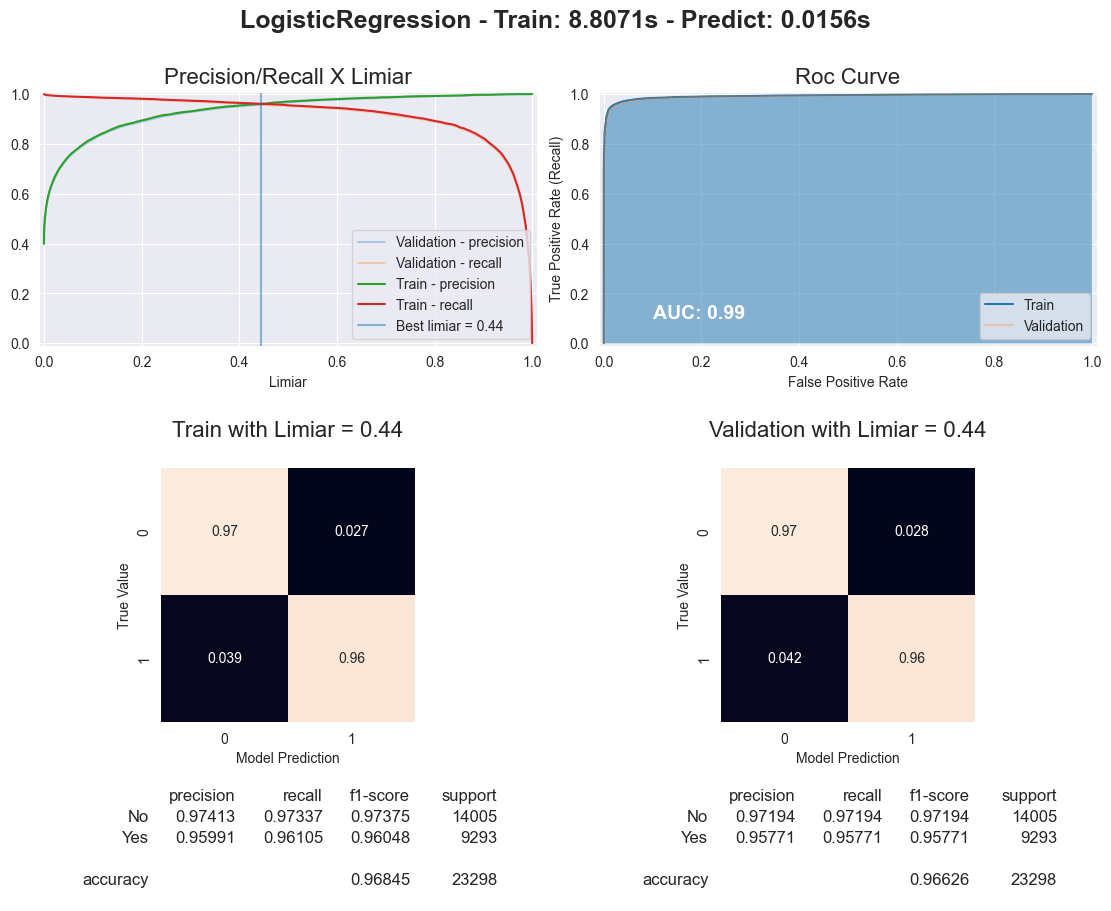

In [8]:
evaluate_model(LogisticRegression(max_iter=1000), X, y, limiar=0.44)

### **2. Random Forest Classifier**

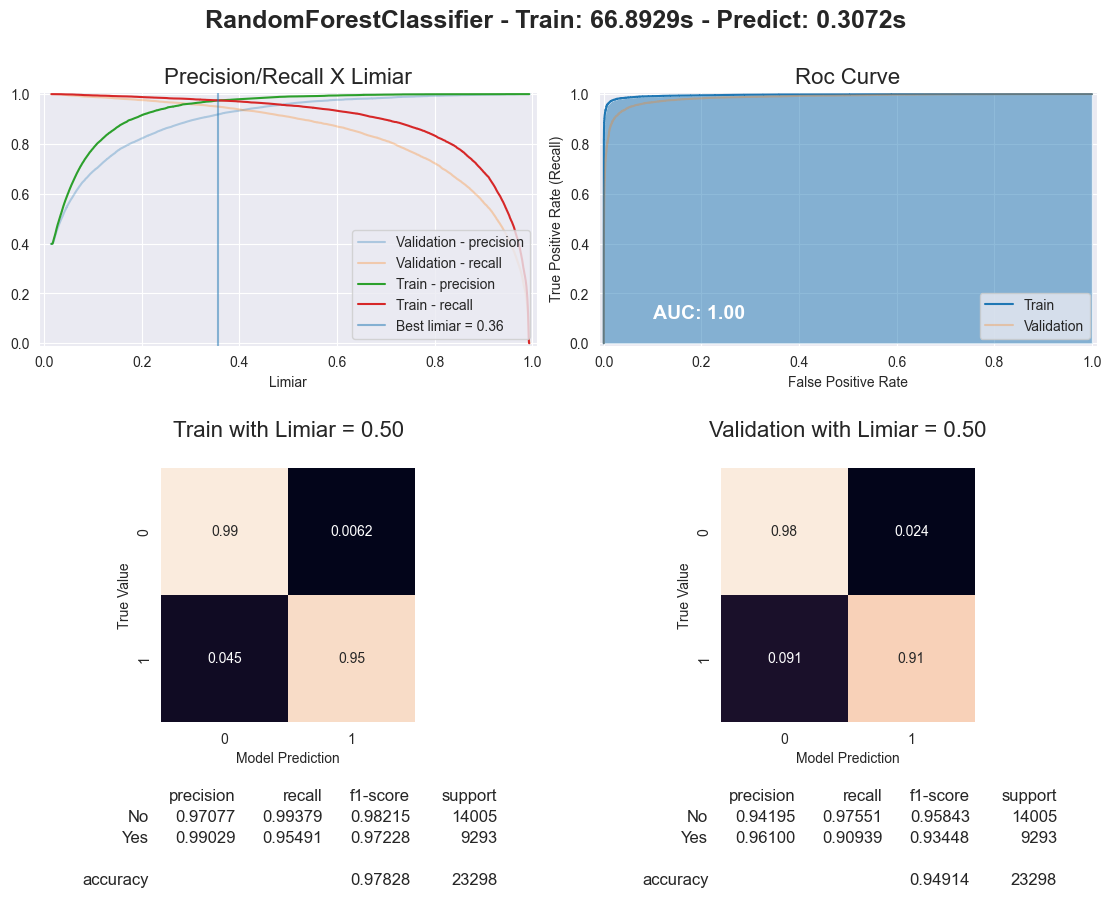

In [10]:
evaluate_model(RandomForestClassifier(max_depth=10), X, y)

### **3. XGBoost Classifier**

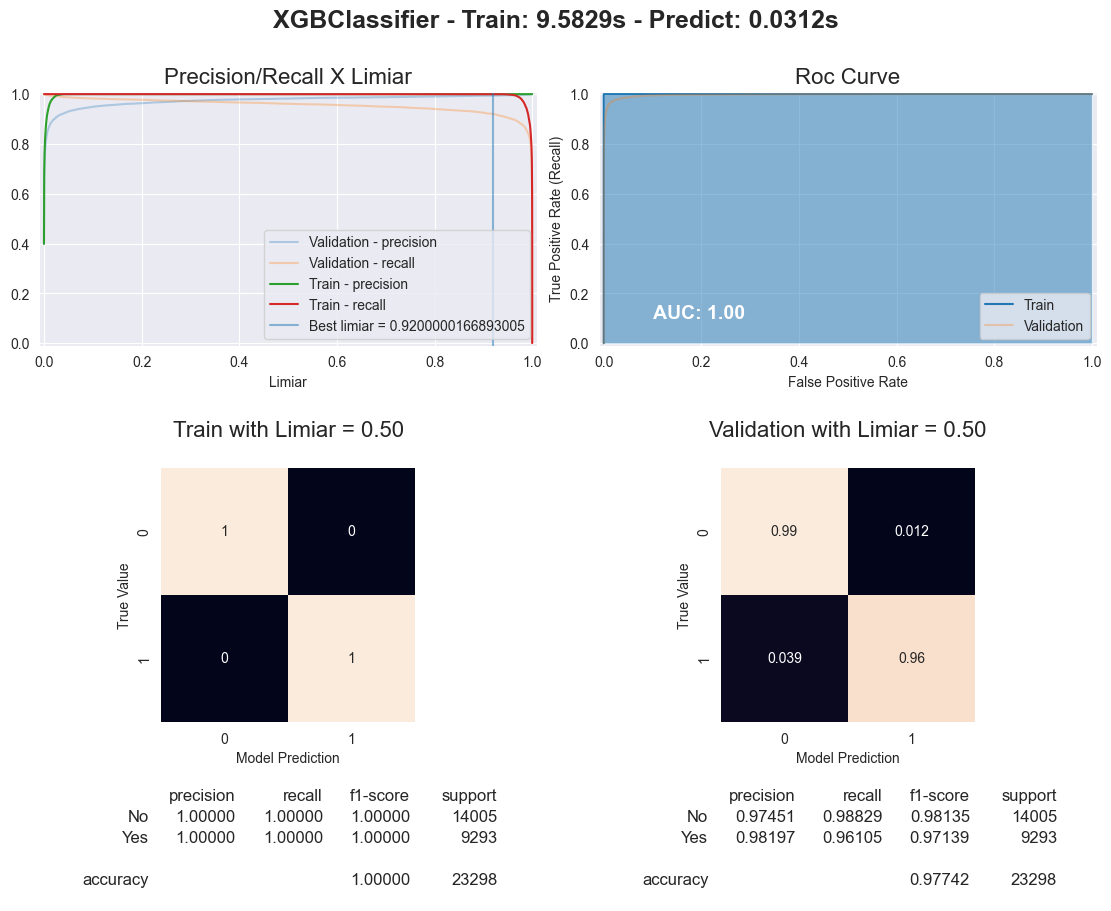

In [9]:
evaluate_model(XGBClassifier(), X, y)

### **4. CatBoost Classifier**

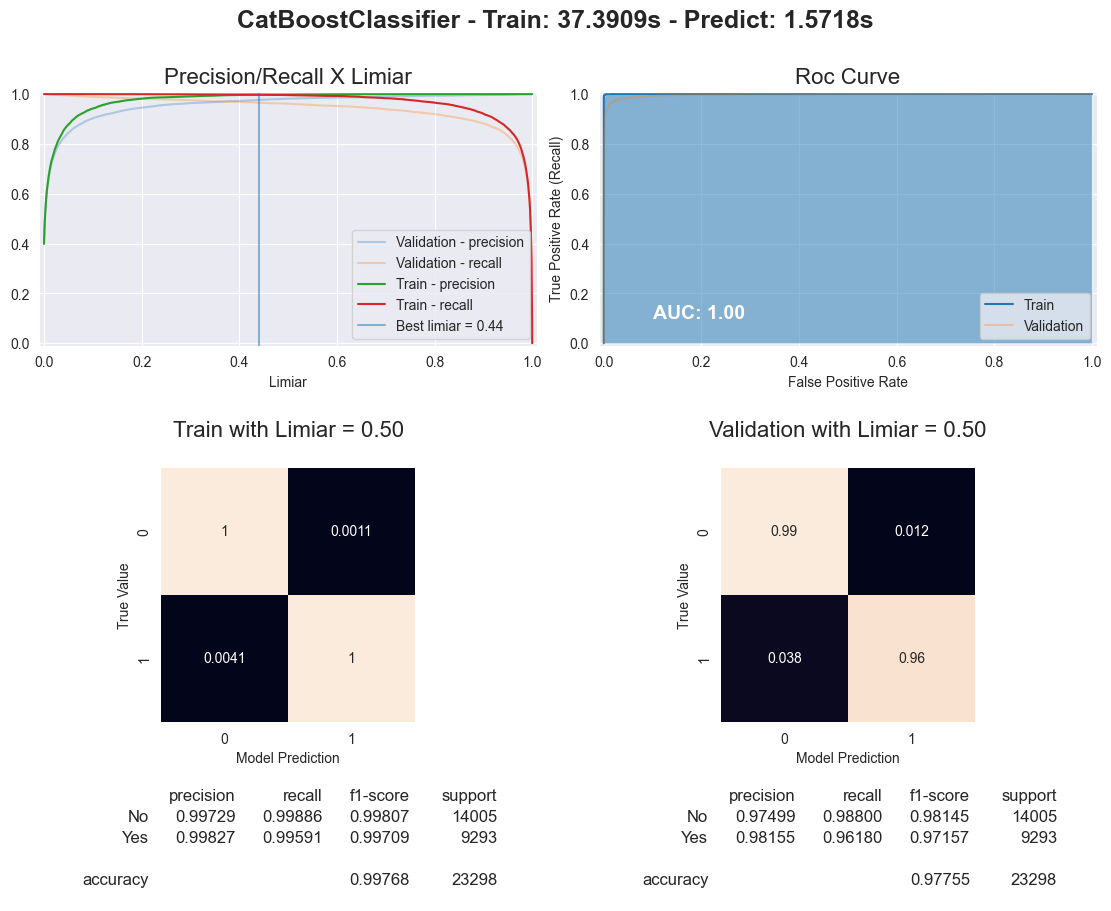

In [11]:
evaluate_model(CatBoostClassifier(iterations=1000, learning_rate=0.03, logging_level='Silent'), X, y)

### **Selecting Models**

A brief overview of each model:

1. **Logistic Regression:**

    * Fast to training and predict;
    * No overfitting/underfitting evidence;
    * Very good roc curve (with auc = 0.99);
    * Good accuracy of 0.96.

2. **Random Forest Classifier:**
    
    * Very slow to train but with fast predict time;
    * Some overfitting evidence;
    * Very good roc curve (but with a bit of overfitting);
    * 0.94(validation) to 0.97(train) accuracy.

3. **XGBoost Classifier:**

    * Fast to training and predict;
    * High overfitting evidence;
    * Very good roc curve (but with a bit of overfitting);
    * 0.97(validation) to 1.0(train) accuracy.

4. **CatBoost Classifier**

    * Slow to train and predict;
    * High overfitting evidence;
    * Very good roc curve (but with a bit of overfitting);
    * 0.97(validation) to 0.99(train) accuracy.

Given this, I'll continuate with LogisticRegression (the best model until now so far) and XGBoost.

**Considerations:**

* I could continuate with CatBoost, but how it takes too many time to train and is very similar to XGBoost, I prefer to not continuate with him;
* Even XGBoost has a bit of overfitting, they can be adjusted to reduce it.

## **Model Tuning**

In this section I'll tune the models selected in the last section. For that, I'll create some helper function that uses randomized search to tune them.

In [9]:
def tune_model(model, parameters, X, y):
    '''
    Helper function that runs randomized search with the given parameters to tune the given model.

    Parameters
    ---
    * model: model to tune
    * parameters: parameters to use in randomized search
    * X: input features
    * y: target feature

    Returns
    ---
    * the RandomizedSearchCV object
    '''

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters,
        n_iter=20,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        verbose=3,
        n_jobs=3,
        random_state=42
    )

    random_search.fit(X, y)

    # show best results
    print('Best parameters:', random_search.best_params_)
    print(f'Best score: {random_search.best_score_:.2f}')

    return random_search

### **1. Tuning Logistic Regression**

In [13]:
# logist regression parameters
lr_params = [
    {
      'solver' : ['lbfgs'],
      'penalty' : ['l2'],
      'C' : uniform(loc=0, scale=10),
      'fit_intercept' : [True, False],
      'class_weight' : [None, 'balanced'],
    }
]

# run tune model method
lr_search = tune_model(LogisticRegression(max_iter=2000, random_state=42), lr_params, X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 9.656320330745594, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.99


In [14]:
# get best model
best_lr_model = lr_search.best_estimator_

#### **Evaluate Model**

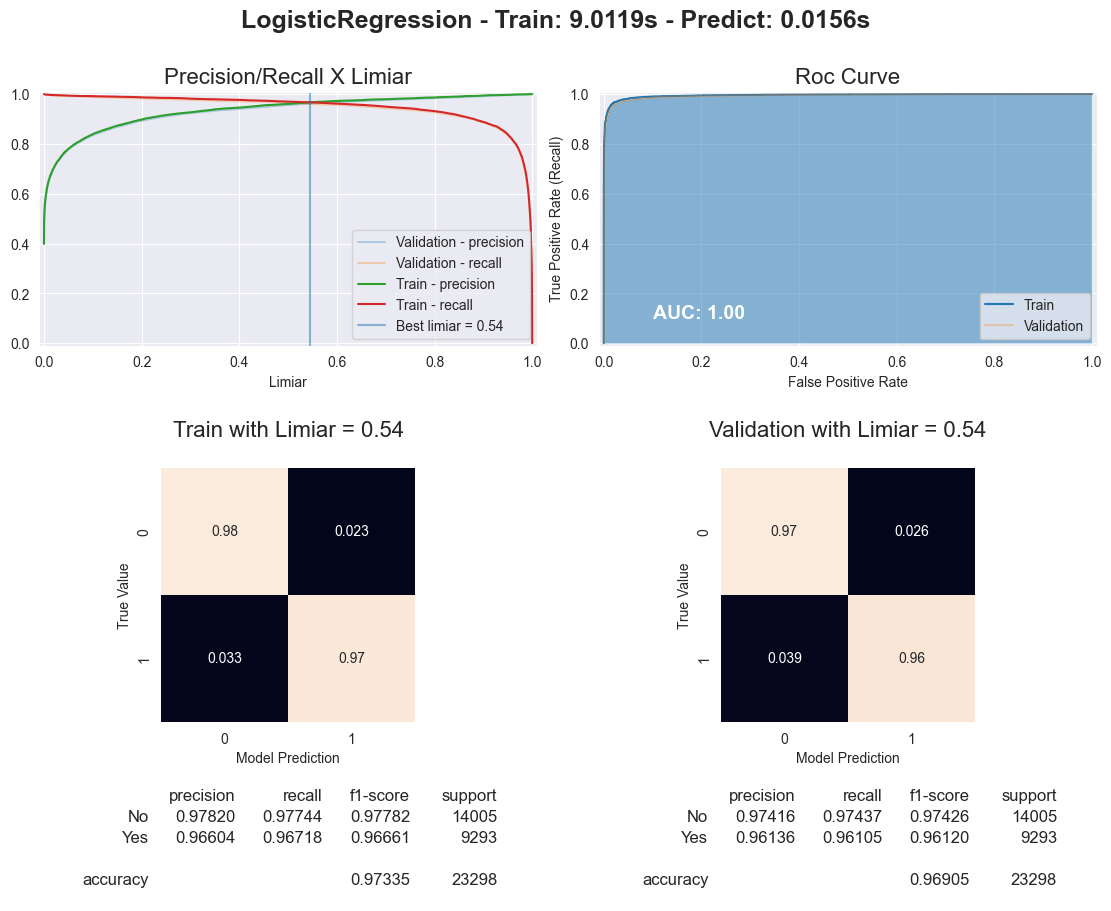

In [16]:
# evaluate model
evaluate_model(best_lr_model, X, y, limiar=0.54)

#### **Interpreting Model**

A way to interpret a logistic regression model is by analysing their coefficients, that way we can infer the features importance.

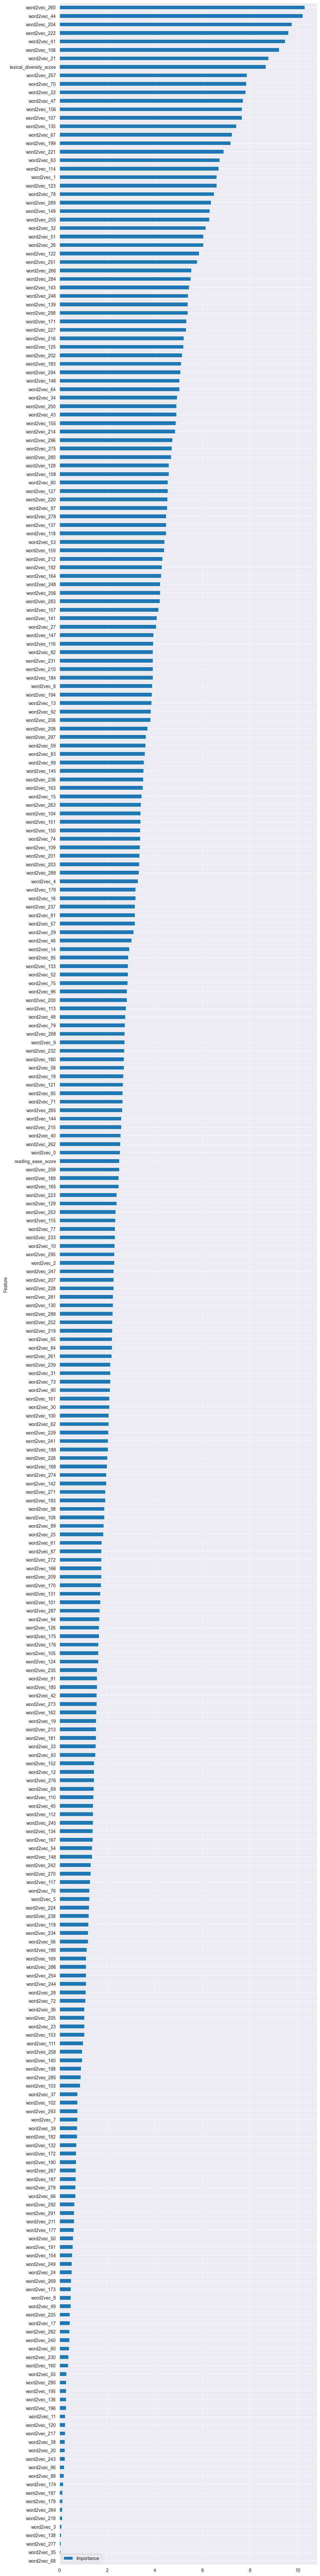

In [18]:
# features names
features_names = [f'word2vec_{i}' for i in range(300)]
features_names.append('lexical_diversity_score')
features_names.append('reading_ease_score')

# get coefficients
lr_model_coefficients = best_lr_model.coef_[0]

# create feature importance table
lr_feature_importance = pd.DataFrame({'Feature' : features_names, 'Importance' : np.abs(lr_model_coefficients)})
lr_feature_importance = lr_feature_importance.sort_values('Importance', ascending=True)

# show result
lr_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 100));

**Observations:**

* the two features with more importance are word2vec_260 and word2vec_44;

* reading_ease_score have a certain importance;

* lexical_diversity_score have more importance than reading_ease_score;

* in general mostly features have a good importance and well balanced.

### **2. Tuning XGBoost Classifier**

In [43]:
# xgboost parameters
xgb_params = {
  'booster' : ['gbtree'],
  'n_estimators' : randint(10, 60),
  'eta' : uniform(0.01, 0.3),
  'max_depth' : randint(1, 15),
  'eval_metric' : ['auc'],
  'max_leaves' : randint(1, 12),
  'objective' : ['binary:logistic'],
  'seed' : [42]
}

# run tune model method
xgb_search = tune_model(XGBClassifier(), xgb_params, X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'booster': 'gbtree', 'eta': 0.2586212527455788, 'eval_metric': 'auc', 'max_depth': 10, 'max_leaves': 9, 'n_estimators': 54, 'objective': 'binary:logistic', 'seed': 42}
Best score: 0.99


In [44]:
# get best model
best_xgb_model = xgb_search.best_estimator_

#### **Evaluate Model**

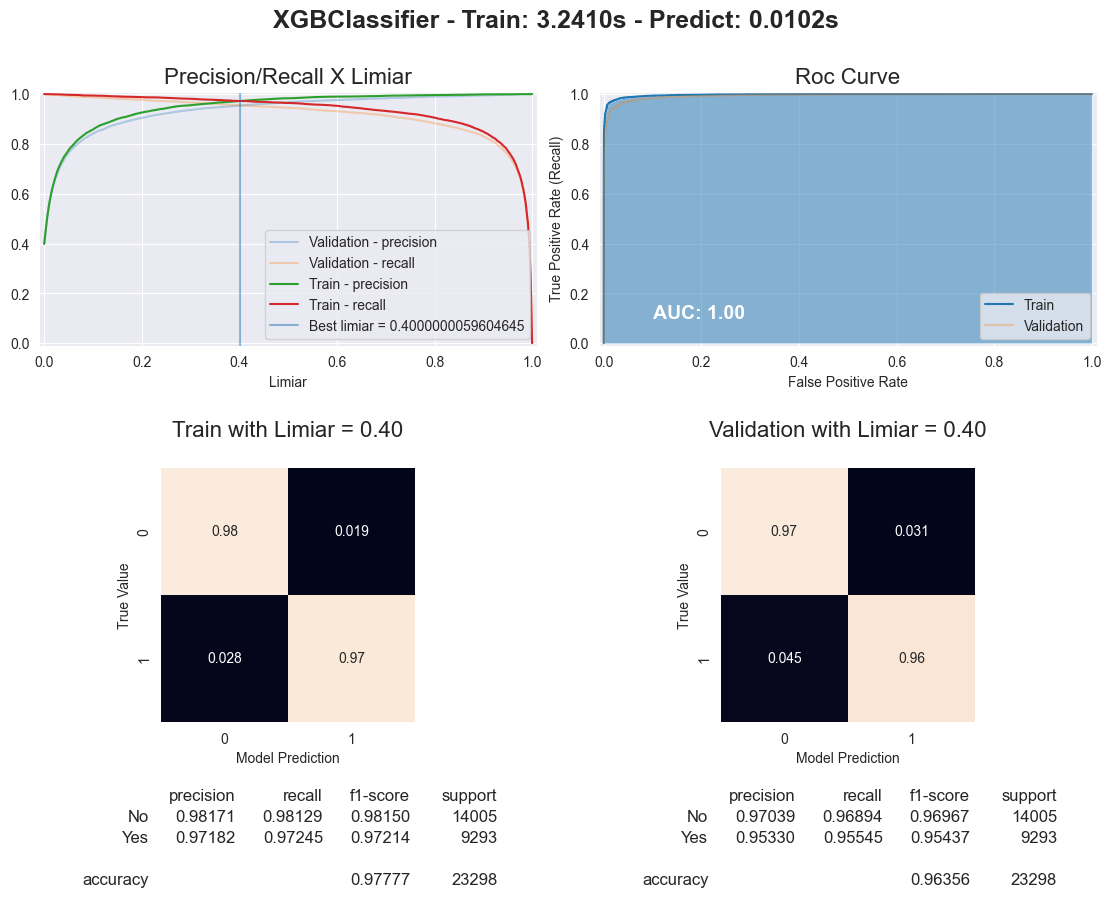

In [45]:
# evaluate model
evaluate_model(best_xgb_model, X, y, limiar=0.4)

#### **Interpreting Model**

A way to interpret a XGBoost model is by analysing their feature importances.

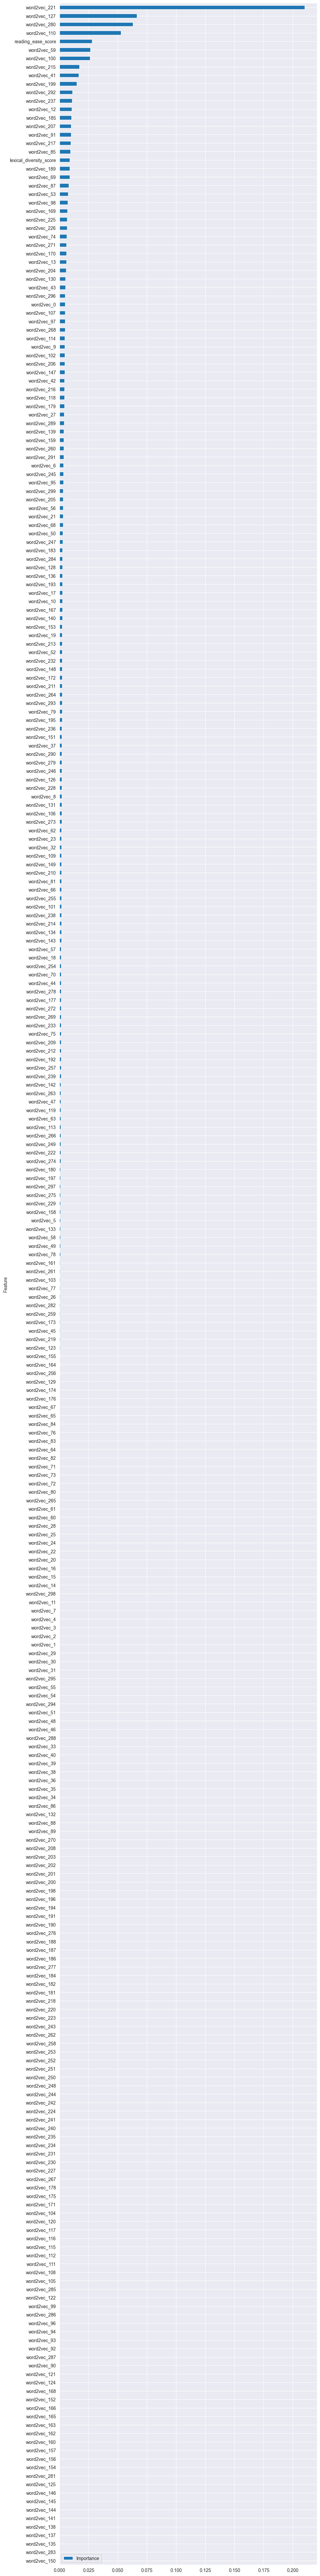

In [46]:
# create feature importance table
xgb_feature_importance = pd.DataFrame({'Feature' : features_names, 'Importance' : np.abs(best_xgb_model.feature_importances_)})
xgb_feature_importance = xgb_feature_importance.sort_values('Importance', ascending=True)

# show result
xgb_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 100));

**Observations:**

* word_2_vec221 is the most important feature so far;

* reading_ease_score and lexical_diversity_score have some importance, but nothing too surprinsing.

## **Final model selection**

A brief sumary of the tuned models:

1. **Logistic Regression Classifier (considering a limiar of 0.54)**

    * This model don't have too much change (cause it was already good);
    * Has a very good performance with 0.96 (validation) to 0.97 (train) of accuracy;
    * Train and predict time are very fast;
    * Stills not having underitting/overfitting evidence;
    * It has a good roc curve, wich give us more confidence that the model has a good sensibility;
    * Features importance are well balanced.

2. **XGBoost Classifier (considering a limiar of 0.40)**

    * This model had a good decrease in overfitting;
    * Has a very good performance with 0.96 (validation) to 0.97 (train) of accuracy;
    * Train and predict time are very fast;
    * It has a good roc curve, wich give us more confidence that the model has a good sensibility;
    * Have one feature with high importance, and the other are much lower than this one.

Considering all the facts above, I'll select the Logistic Regression because his features importances are more balanced, and even the XGBoost not presenting overfitting on the available data, maybe will have bad results on real data  with different context, dued to it's high importance to an unique feature.

## **Evaluating final model on test dataset**

In [48]:
# loading test dataset
test_data = pd.read_csv('../artifacts/test.csv')

In [49]:
# split input and target features
X_test = test_data.iloc[:, 0].values
y_test = test_data.iloc[:, 1].values

In [50]:
# preprocessing test data
X_test = preprocessor.transform(X_test)

In [51]:
# predict values
y_test_pred = best_lr_model.predict_proba(X_test)[:, 1] >= 0.54

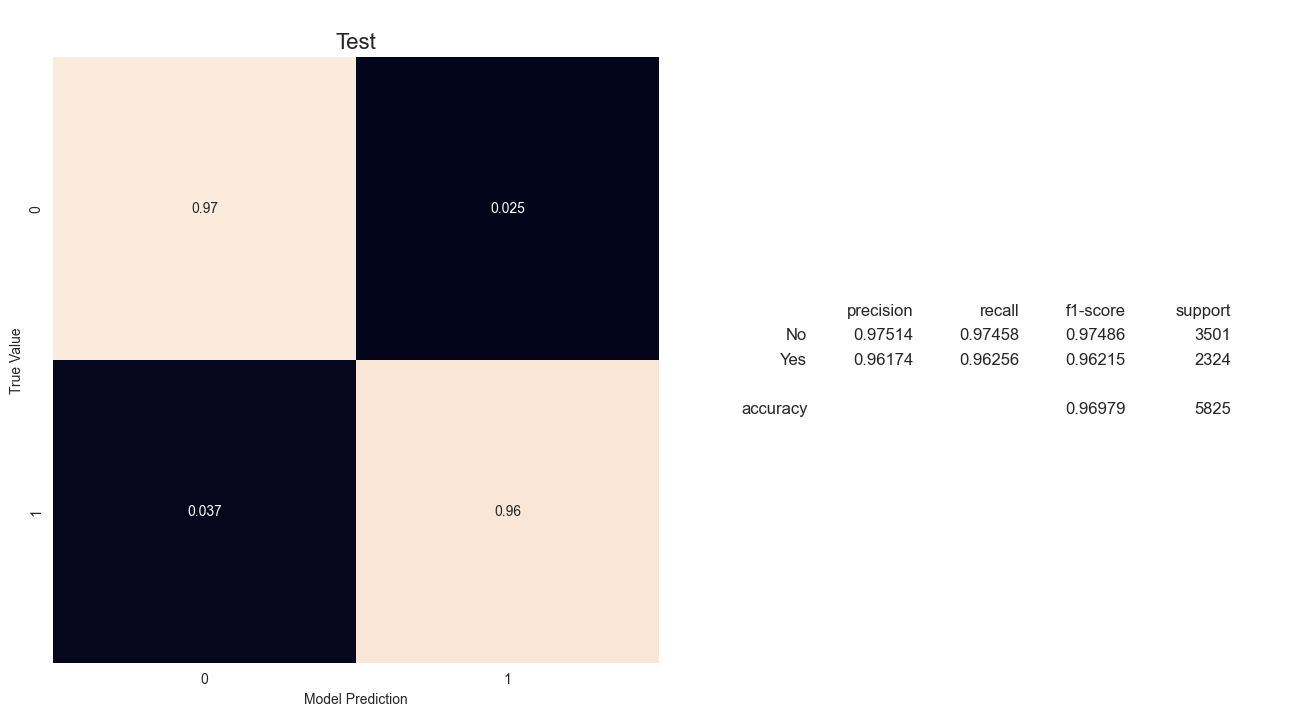

In [52]:
# show result
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))

# plot confusion matrix
plot_confusion_matrix('Test', y_test, y_test_pred, ax0)

# plot classification report
plot_classification_report(y_test, y_test_pred, ax1)

plt.tight_layout()

The results above show us metrics very similar to the training data, it give us more certain that our model is not overfitted. In general we can conclude that the model find AI texts 96% of times with good balance bettween precision and recall.

## **Conclusion**

At this stage I can conclude that the Logistic Regression is the best model to my goal. Basicaly I can say that:

* The model is fast to predict results;
* Had a good accuracy;
* All metrics appears to be well balanced;
* It has no evidence of overfitting.